# In Depth: k-Means Clustering

# In Depth: k-Means Clustering

In the previous few sections, we have explored one category of unsupervised machine learning models: dimensionality reduction.
Here we will move on to another class of unsupervised machine learning models: clustering algorithms.
Clustering algorithms seek to learn, from the properties of the data, an optimal division or discrete labeling of groups of points.

Many clustering algorithms are available in Scikit-Learn and elsewhere, but perhaps the simplest to understand is an algorithm known as *k-means clustering*, which is implemented in ``sklearn.cluster.KMeans``.

We begin with the standard imports:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

## Introducing k-Means

The *k*-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset.
It accomplishes this using a simple conception of what the optimal clustering looks like:

- The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
- Each point is closer to its own cluster center than to other cluster centers.

Those two assumptions are the basis of the *k*-means model.
We will soon dive into exactly *how* the algorithm reaches this solution, but for now let's take a look at a simple dataset and see the *k*-means result.

First, let's generate a two-dimensional dataset containing four distinct blobs.
To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualization

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


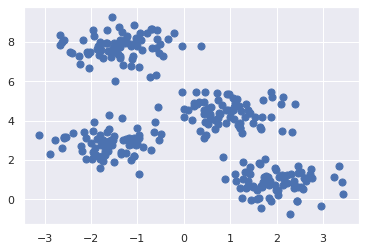

In [3]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

By eye, it is relatively easy to pick out the four clusters.
The *k*-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:

In [4]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Let's visualize the results by plotting the data colored by these labels.
We will also plot the cluster centers as determined by the *k*-means estimator:

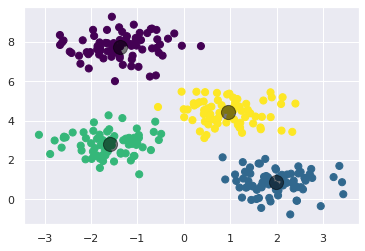

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

The good news is that the *k*-means algorithm (at least in this simple case) assigns the points to clusters very similarly to how we might assign them by eye.
But you might wonder how this algorithm finds these clusters so quickly! After all, the number of possible combinations of cluster assignments is exponential in the number of data points—an exhaustive search would be very, very costly.
Fortunately for us, such an exhaustive search is not necessary: instead, the typical approach to *k*-means involves an intuitive iterative approach known as *expectation–maximization*.

## k-Means Algorithm: Expectation–Maximization

Expectation–maximization (E–M) is a powerful algorithm that comes up in a variety of contexts within data science.
*k*-means is a particularly simple and easy-to-understand application of the algorithm, and we will walk through it briefly here.
In short, the expectation–maximization approach here consists of the following procedure:

1. Guess some cluster centers
2. Repeat until converged
   1. *E-Step*: assign points to the nearest cluster center
   2. *M-Step*: set the cluster centers to the mean 

Here the "E-step" or "Expectation step" is so-named because it involves updating our expectation of which cluster each point belongs to.
The "M-step" or "Maximization step" is so-named because it involves maximizing some fitness function that defines the location of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.

The literature about this algorithm is vast, but can be summarized as follows: under typical circumstances, each repetition of the E-step and M-step will always result in a better estimate of the cluster characteristics.

We can visualize the algorithm as shown in the following figure.
For the particular initialization shown here, the clusters converge in just three iterations.
For an interactive version of this figure, refer to the code in [the Appendix](06.00-Figure-Code.ipynb#Interactive-K-Means).

![(run code in Appendix to generate image)](figures/05.11-expectation-maximization.png)
[figure source in Appendix](06.00-Figure-Code.ipynb#Expectation-Maximization)

The *k*-Means algorithm is simple enough that we can write it in a few lines of code.
The following is a very basic implementation:

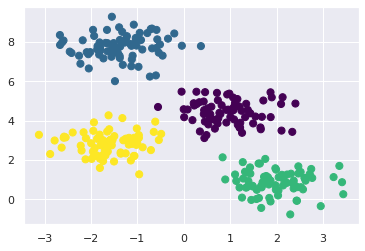

In [6]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Most well-tested implementations will do a bit more than this under the hood, but the preceding function gives the gist of the expectation–maximization approach.

### Caveats of expectation–maximization

There are a few issues to be aware of when using the expectation–maximization algorithm.

#### The globally optimal result may not be achieved
First, although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the *global* best solution.
For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results:

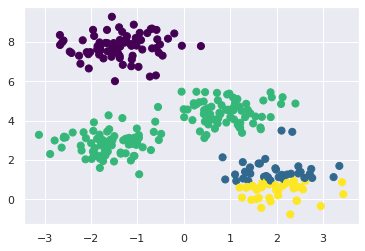

In [7]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Here the E–M approach has converged, but has not converged to a globally optimal configuration. For this reason, it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (set by the ``n_init`` parameter, which defaults to 10).

#### The number of clusters must be selected beforehand
Another common challenge with *k*-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data.
For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters:

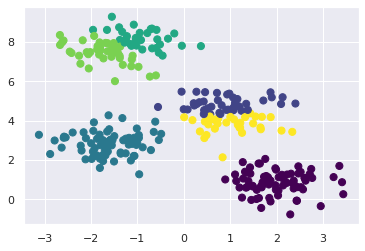

In [8]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Whether the result is meaningful is a question that is difficult to answer definitively; one approach that is rather intuitive, but that we won't discuss further here, is called [silhouette analysis](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).

Alternatively, you might use a more complicated clustering algorithm which has a better quantitative measure of the fitness per number of clusters (e.g., Gaussian mixture models; see [In Depth: Gaussian Mixture Models](05.12-Gaussian-Mixtures.ipynb)) or which *can* choose a suitable number of clusters (e.g., DBSCAN, mean-shift, or affinity propagation, all available in the ``sklearn.cluster`` submodule)

#### k-means is limited to linear cluster boundaries
The fundamental model assumptions of *k*-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

In particular, the boundaries between *k*-means clusters will always be linear, which means that it will fail for more complicated boundaries.
Consider the following data, along with the cluster labels found by the typical *k*-means approach:

In [9]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

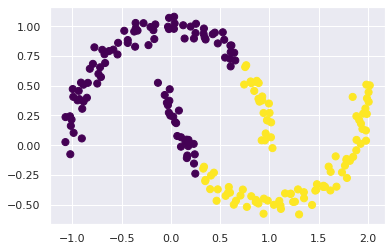

In [10]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

This situation is reminiscent of the discussion in [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb), where we used a kernel transformation to project the data into a higher dimension where a linear separation is possible.
We might imagine using the same trick to allow *k*-means to discover non-linear boundaries.

One version of this kernelized *k*-means is implemented in Scikit-Learn within the ``SpectralClustering`` estimator.
It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a *k*-means algorithm:

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


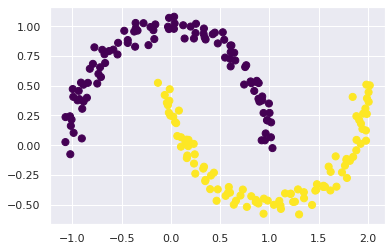

In [11]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

We see that with this kernel transform approach, the kernelized *k*-means is able to find the more complicated nonlinear boundaries between clusters.

#### k-means can be slow for large numbers of samples
Because each iteration of *k*-means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows.
You might wonder if this requirement to use all data at each iteration can be relaxed; for example, you might just use a subset of the data to update the cluster centers at each step.
This is the idea behind batch-based *k*-means algorithms, one form of which is implemented in ``sklearn.cluster.MiniBatchKMeans``.
The interface for this is the same as for standard ``KMeans``; we will see an example of its use as we continue our discussion.

## Examples

Being careful about these limitations of the algorithm, we can use *k*-means to our advantage in a wide variety of situations.
We'll now take a look at a couple examples.

### Example 1: k-means on digits

To start, let's take a look at applying *k*-means on the same simple digits data that we saw in [In-Depth: Decision Trees and Random Forests](05.08-Random-Forests.ipynb) and [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb).
Here we will attempt to use *k*-means to try to identify similar digits *without using the original label information*; this might be similar to a first step in extracting meaning from a new dataset about which you don't have any *a priori* label information.

We will start by loading the digits and then finding the ``KMeans`` clusters.
Recall that the digits consist of 1,797 samples with 64 features, where each of the 64 features is the brightness of one pixel in an 8×8 image:

In [12]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

The clustering can be performed as we did before:

In [13]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

The result is 10 clusters in 64 dimensions.
Notice that the cluster centers themselves are 64-dimensional points, and can themselves be interpreted as the "typical" digit within the cluster.
Let's see what these cluster centers look like:

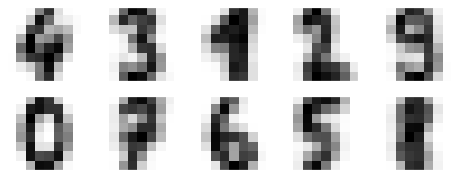

In [14]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

We see that *even without the labels*, ``KMeans`` is able to find clusters whose centers are recognizable digits, with perhaps the exception of 1 and 8.

Because *k*-means knows nothing about the identity of the cluster, the 0–9 labels may be permuted.
We can fix this by matching each learned cluster label with the true labels found in them:

In [15]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

Now we can check how accurate our unsupervised clustering was in finding similar digits within the data:

In [16]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7952142459654981

With just a simple *k*-means algorithm, we discovered the correct grouping for 80% of the input digits!
Let's check the confusion matrix for this:

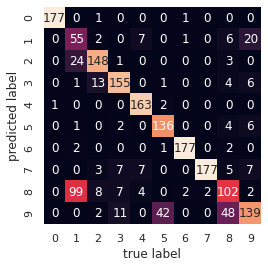

In [17]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

As we might expect from the cluster centers we visualized before, the main point of confusion is between the eights and ones.
But this still shows that using *k*-means, we can essentially build a digit classifier *without reference to any known labels*!

Just for fun, let's try to push this even farther.
We can use the t-distributed stochastic neighbor embedding (t-SNE) algorithm (mentioned in [In-Depth: Manifold Learning](05.10-Manifold-Learning.ipynb)) to pre-process the data before performing *k*-means.
t-SNE is a nonlinear embedding algorithm that is particularly adept at preserving points within clusters.
Let's see how it does:

In [18]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

0.9371174179187535

That's nearly 92% classification accuracy *without using the labels*.
This is the power of unsupervised learning when used carefully: it can extract information from the dataset that it might be difficult to do by hand or by eye.

### Example 2: *k*-means for color compression

One interesting application of clustering is in color compression within images.
For example, imagine you have an image with millions of colors.
In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

For example, consider the image shown in the following figure, which is from the Scikit-Learn ``datasets`` module (for this to work, you'll have to have the ``pillow`` Python package installed).

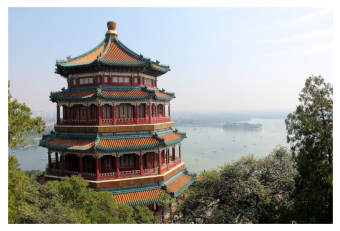

In [19]:
# Note: this requires the ``pillow`` package to be installed
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

The image itself is stored in a three-dimensional array of size ``(height, width, RGB)``, containing red/blue/green contributions as integers from 0 to 255:

In [20]:
china.shape

(427, 640, 3)

One way we can view this set of pixels is as a cloud of points in a three-dimensional color space.
We will reshape the data to ``[n_samples x n_features]``, and rescale the colors so that they lie between 0 and 1:

In [21]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

We can visualize these pixels in this color space, using a subset of 10,000 pixels for efficiency:

In [22]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

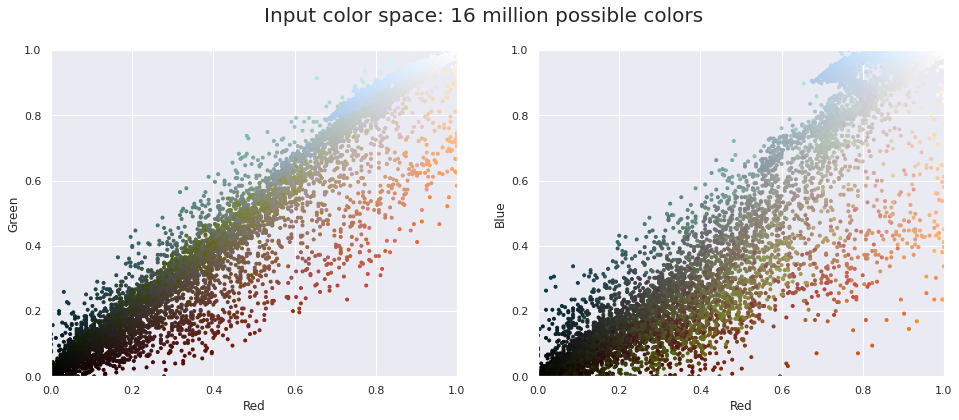

In [23]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Now let's reduce these 16 million colors to just 16 colors, using a *k*-means clustering across the pixel space.
Because we are dealing with a very large dataset, we will use the mini batch *k*-means, which operates on subsets of the data to compute the result much more quickly than the standard *k*-means algorithm:

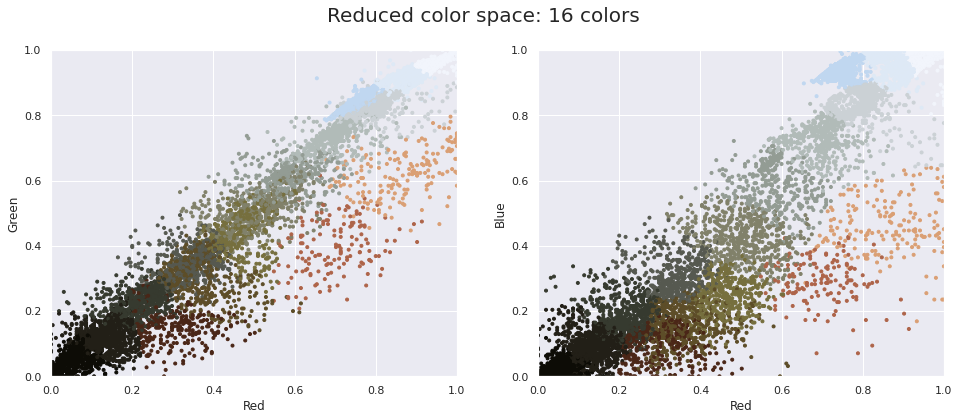

In [24]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

The result is a re-coloring of the original pixels, where each pixel is assigned the color of its closest cluster center.
Plotting these new colors in the image space rather than the pixel space shows us the effect of this:

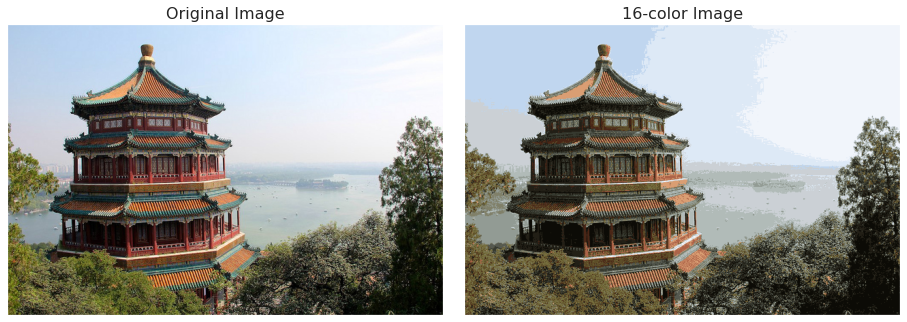

In [25]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

Some detail is certainly lost in the rightmost panel, but the overall image is still easily recognizable.
This image on the right achieves a compression factor of around 1 million!
While this is an interesting application of *k*-means, there are certainly better way to compress information in images.
But the example shows the power of thinking outside of the box with unsupervised methods like *k*-means.

## K-Medoids Algorithm

both k-means and k-medoids are partitional, which involves breaking the dataset into groups. K-medoids attempts to minimize the sum of dissimilarities between objects labeled to be in a cluster and one of the objects designed as the representative of that cluster. These of representatives are called medoids.

 For the beginning, we import the important libraries : 


In [26]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

We load the dataset. We will use a copy of iris data set from sklearn library.

In [27]:
# Dataset
iris = datasets.load_iris()
data = pd.DataFrame(iris.data, columns = iris.feature_names)

target = iris.target_names
labels = iris.target

We scaling the data for these types of problem when data is on different scales across the columns. Since there is no missing data, let’s proceed with the scaling. We are utilized the MinMaxScaler class from the same sklearn library 

In [28]:
# Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)

The output of data scaling : 

In [29]:
data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.222222,0.625000,0.067797,0.041667
1,0.166667,0.416667,0.067797,0.041667
2,0.111111,0.500000,0.050847,0.041667
3,0.083333,0.458333,0.084746,0.041667
4,0.194444,0.666667,0.067797,0.041667
...,...,...,...,...
145,0.666667,0.416667,0.711864,0.916667
146,0.555556,0.208333,0.677966,0.750000
147,0.611111,0.416667,0.711864,0.791667
148,0.527778,0.583333,0.745763,0.916667


There are 4 features which might not be ideal for visualization and fitting of the clustering model since some of them might be highly correlated. Therefore, we will employ the Principal Component Analysis (PCA) to transform 4-dimensional data into 3-dimensional data while keeping the significance of those predictors with the PCA class from sklearn. 

In [30]:
# PCA Transformation

from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
principalComponents = pca.fit_transform(data)
PCAdf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])

datapoints = PCAdf.values
m, f = datapoints.shape
k = 3

The output:

In [31]:
datapoints

array([[-6.30702931e-01,  1.07577910e-01, -1.87190977e-02],
       [-6.22904943e-01, -1.04259833e-01, -4.91420253e-02],
       [-6.69520395e-01, -5.14170597e-02,  1.96441728e-02],
       [-6.54152759e-01, -1.02884871e-01,  2.32185515e-02],
       [-6.48788056e-01,  1.33487576e-01,  1.51155243e-02],
       [-5.35272778e-01,  2.89615724e-01,  2.54378874e-02],
       [-6.56537790e-01,  1.07244911e-02,  9.18347789e-02],
       [-6.25780499e-01,  5.71335411e-02, -1.40277647e-02],
       [-6.75643504e-01, -2.00703283e-01,  3.59520802e-02],
       [-6.45644619e-01, -6.72080097e-02, -6.17055833e-02],
       [-5.97408238e-01,  2.17151953e-01, -5.12740810e-02],
       [-6.38943190e-01,  3.25988375e-02,  2.44981902e-02],
       [-6.61612593e-01, -1.15605495e-01, -5.47803418e-02],
       [-7.51967943e-01, -1.71313322e-01,  4.76777938e-02],
       [-6.00371589e-01,  3.80240692e-01, -8.51695344e-02],
       [-5.52157227e-01,  5.15255982e-01,  3.82732690e-02],
       [-5.77053593e-01,  2.93709492e-01

Visualize on a 3-D plane:

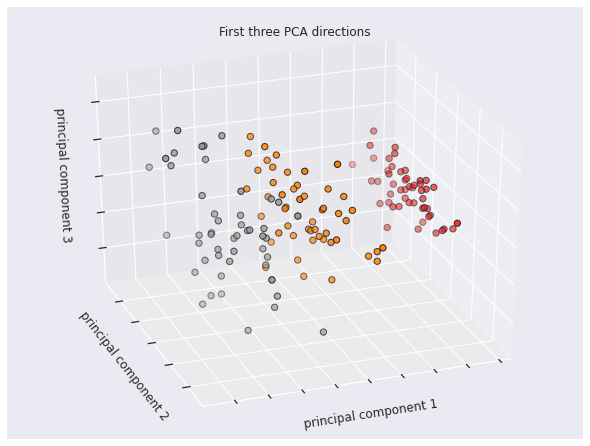

In [32]:
# Visualization

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev = -150, azim = 110)
X_reduced = datapoints
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c = labels, cmap = plt.cm.Set1, edgecolor = 'k', s = 40)
ax.set_title("First three PCA directions")
ax.set_xlabel("principal component 1")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("principal component 2")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("principal component 3")
ax.w_zaxis.set_ticklabels([])
plt.show()

### Medoid Initialization

To start the algorithm, we need an initial guess. Lets randomly choose k observation from the data. In this case, k = 3 representing 3 different types of iris.  Next we will create function, init_medoids(X,k), so that it randomly selects k of the given observations to serve as medoids. It should return a NumPy array of size (k x d), where d is the number of columns of X.

In [33]:
def init_medoids(X, k):
  from numpy.random import choice, seed

  seed(1)
  samples = choice(len(X), size = k, replace=False)
  return X[samples, :]

medoids_initial = init_medoids(datapoints, 3)

After initializing 3 random medoid from the data points, we have :

In [34]:
medoids_initial

array([[-0.60037159,  0.38024069, -0.08516953],
       [-0.15863457, -0.28913985,  0.0524159 ],
       [ 0.21396272,  0.059963  , -0.11409813]])

### Computing the Distances

Implementing a function that computes a distance matrix (S = s_ij) such that s_ij = d^p_ij is the Minkowski distance of order p point x_i to medoid. It should return a NumPy matrix S with shape (m,k).  
 

In [35]:
def compute_d_p(X, medoids, p):
  m = len(X)
  medoids_shape = medoids.shape
  # If a 1-D array is provided
  # it will be reshaped to a single row 2-D array
  if len(medoids_shape) == 1:
    medoids = medoids.reshape((1, len(medoids)))
  k = len(medoids)

  S = np.empty((m, k))

  for i in range (m): 
    d_i = np.linalg.norm(X[i, :] - medoids, ord = p, axis = 1)
    S[i, :] = d_i**p
  
  return S

S = compute_d_p(datapoints, medoids_initial, 2)

Based on that, the matrix S are : 

In [36]:
S

array([[0.07968064, 0.3852937 , 0.7248244 ],
       [0.23654649, 0.26004161, 0.73153592],
       [0.20209589, 0.31859043, 0.81083493],
       [0.2480507 , 0.28108167, 0.79899978],
       [0.07328835, 0.42025569, 0.76644093],
       [0.02468474, 0.47754216, 0.6335645 ],
       [0.17102739, 0.33938008, 0.80260393],
       [0.11010499, 0.34254533, 0.71519075],
       [0.35783221, 0.27539032, 0.88186121],
       [0.20281054, 0.29945624, 0.75784222],
       [0.02775562, 0.45960533, 0.68697806],
       [0.13436964, 0.33499155, 0.74740623],
       [0.2505374 , 0.29459209, 0.80097502],
       [0.3448417 , 0.36595003, 1.01268223],
       [0.        , 0.66213165, 0.76655503],
       [0.03579188, 0.80211274, 0.81744851],
       [0.02127369, 0.51529454, 0.70108133],
       [0.08302796, 0.35731766, 0.68556492],
       [0.01509555, 0.47944961, 0.59289047],
       [0.0437377 , 0.46409076, 0.73404497],
       [0.0792879 , 0.33420167, 0.59754411],
       [0.06094364, 0.39785527, 0.67347669],
       [0.

### Cluster Assignment

Now we build a function that acts on the distance matrix S to assign a “Cluster Label” of 0, 1 and 2 to each point using the minimum distance to find the “most similar” medoid. 

In [37]:
def assign_labels(S):
  return np.argmin(S, axis = 1)

labels = assign_labels(S)

We then get the labels for the data points of the first iteration :  

In [38]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2,
       2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

### Swap Test

In this step, for each medoid j and each data point i associated to j swap and i and compute the total cost of the configuration as Step 29. Select the medoid j with the lowest cost of the configuration. That is, for each cluster, search if any of the points in the cluster decreases the average dissimilarity coefficient. Select the point that decreases this coefficient the most as the new medoid for this cluster.

In [39]:
def update_medoids(X, medoids, p):
  S = compute_d_p(datapoints, medoids, p)
  labels = assign_labels(S)

  out_medoids = medoids

  for i in set(labels):
    avg_dissimilarity = np.sum(compute_d_p(datapoints, medoids[i], p))
    cluster_points = datapoints[labels == i]

    for datap in cluster_points:
      new_medoid = datap
      new_dissimalarity = np.sum(compute_d_p(datapoints, datap, p))

      if new_dissimalarity < avg_dissimilarity:
        avg_dissimilarity = new_dissimalarity

        out_medoids[i] = datap
        
  return out_medoids

We also need a function that checks whether the medoid have “moved”, given two instances of the medoid values. This is the function to check whether the medoids no longer moves and the iteration should be stopped.

In [40]:
def has_converged(old_medoids, medoids):
  return set([tuple(x) for x in old_medoids]) == set([tuple(x) for x in medoids])

### Putting all Together

When we combined all the function above, we essentially combine the steps of a k-medois algorithm : 

In [41]:
#Full algorithm

def kmedoids(X, k, p, starting_medoids=None, max_steps=np.inf):
    if starting_medoids is None:
        medoids = init_medoids(X, k)
    else:
        medoids = starting_medoids

    converged = False
    labels = np.zeros(len(X))
    i = 1
    while (not converged) and (i <= max_steps):
        old_medoids = medoids.copy()

        S = compute_d_p(X, medoids, p)

        labels = assign_labels(S)

        medoids = update_medoids(X, medoids, p)

        converged = has_converged(old_medoids, medoids)
        i += 1
    return (medoids,labels)

results = kmedoids(datapoints, 3, 2)
final_medoids = results[0]
data['clusters'] = results[1]

By running the function over the data points that we have, the final medoids are found to be :  

In [42]:
final_medoids

array([[-0.50609386,  0.02794708,  0.02628302],
       [-0.00826092, -0.0866611 ,  0.05357911],
       [ 0.03302937, -0.04297085,  0.01560933]])

And the cluster labels of each data points are : 

In [43]:
results[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2,
       2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

By considering “inexact” matches, the k-medoids above labels correctly 94.7% of the data points. This is just for demonstration purpose of how the algorithm works and this number does not mean much as we did not split the data into training and testing set. 

In [44]:
# Count
def mark_matches(a, b, exact = False):
  assert a.shape == b.shape
  a_int = a.astype(dtype=int)
  b_int = a.astype(dtype=int)
  all_axes = tuple(range(len(a.shape)))
  assert ((a_int == 0) | (a_int == 1) | (a_int == 2)).all()
  assert ((b_int == 0) | (b_int == 1) | (b_int == 2)).all()

  exact_matches = (a_int == b_int)
  if (exact):
    return exact_matches
  
  assert exact == False
  num_exact_matches = np.sum(exact_matches)
  if (2 * num_exact_matches) >= np.prod (a.shape):
    return exact_matches
  return exact_matches == False # Invert

In [45]:
def count_matches(a, b, exact = False):
  matches = mark_matches(a, b, exact = exact)
  return np.sum(matches)

n_matches = count_matches(labels, data['clusters'])
print(n_matches, "matches out of", len(data), "data points", "(~ {:.1f}%)".format(100.0 * n_matches / len(labels)))

150 matches out of 150 data points (~ 100.0%)


## k-Modes Algorithm : Unsupervised Learning for Categorical Data 

Introduced in 1998 by ZHehue Huang, k-modes provides a much needed alternative to k-means when the data at hand are categorical rather than numeric. Categorical here means that we can make a finite list all possible categories as column headings and then for each row, indicate whether the category indicated is observed.  
For example, we use data categorical from UCI Machine Learning, Bank Marketing (UCI Repository: https://archive.ics.uci.edu/ml/datasets/bank+marketing).

Import the important libraries : 

In [46]:
# supress warnings
import warnings
warnings.filterwarnings('ignore')

# Importing all required packages
import numpy as np
import pandas as pd

# Data viz lib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pyplot import xticks

Reading the data and understanding the data and shown the data

In [47]:
bank = pd.read_csv('Datasets/bank-additional-full.csv', delimiter = ';')
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Show the data columns and importing the categorical columns : 

In [48]:
bank.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [49]:
# Importing Categorical Columns
bank_cust = bank[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']]

Show the data after importing : 

In [50]:
bank_cust.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent
2,37,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent
4,56,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent


We need converting age into categorical value : 

In [51]:
# Converting age into categorical variable
bank_cust['age_bin'] = pd.cut(bank_cust['age'], [0, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                              labels=['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100'])
bank_cust = bank_cust.drop('age', axis = 1)

Take a look the data after converting : 

In [52]:
bank_cust.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,age_bin
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent,50-60
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent,50-60
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent,30-40
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent,30-40
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent,50-60


Data inspection; we need to know the data shape, describe and information from data : 

In [53]:
bank_cust.shape

(41188, 11)

In [54]:
bank_cust.describe()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,age_bin
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,9
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,30-40
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,16385


In [55]:
bank_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   job          41188 non-null  object  
 1   marital      41188 non-null  object  
 2   education    41188 non-null  object  
 3   default      41188 non-null  object  
 4   housing      41188 non-null  object  
 5   loan         41188 non-null  object  
 6   contact      41188 non-null  object  
 7   month        41188 non-null  object  
 8   day_of_week  41188 non-null  object  
 9   poutcome     41188 non-null  object  
 10  age_bin      41188 non-null  category
dtypes: category(1), object(10)
memory usage: 3.2+ MB


Data cleaning : first, we need to checking null values in the data. After that, we need to encoding the data. In this case, we use LabelEncoder. 

In [56]:
# Checking Null values

bank_cust.isnull().sum() * 100/bank_cust.shape[0]

job            0.0
marital        0.0
education      0.0
default        0.0
housing        0.0
loan           0.0
contact        0.0
month          0.0
day_of_week    0.0
poutcome       0.0
age_bin        0.0
dtype: float64

There are no NULL values in the dataset, hence it is clean.  

In [57]:
# First we will keep a copy of data
bank_cust_copy = bank_cust.copy()

Data preprocessing with LabelEncoder :

In [58]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
bank_cust = bank_cust.apply(le.fit_transform)
bank_cust.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,age_bin
0,3,1,0,0,0,0,1,6,1,1,4
1,7,1,3,1,0,0,1,6,1,1,4
2,7,1,3,0,2,0,1,6,1,1,2
3,0,1,1,0,0,0,1,6,1,1,2
4,7,1,3,0,0,2,1,6,1,1,4


 Installing the kmodes to building the model  

In [59]:
!pip install kmodes

In [60]:
pip install --upgrade kmodes

Requirement already up-to-date: kmodes in /usr/local/lib/python3.7/dist-packages (0.11.0)


Importing the important libraries :

In [61]:
# Importing Libraries
from kmodes.kmodes import KModes

Using k-modes with “Cao” Initialization : 

In [62]:
km_cao = KModes(n_clusters=2, init = "Cao", n_init = 1, verbose = 1)
fitClusters_cao = km_cao.fit_predict(bank_cust)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5322, cost: 192203.0
Run 1, iteration: 2/100, moves: 1160, cost: 192203.0


In [63]:
# Predicted Clusters
fitClusters_cao

array([1, 1, 0, ..., 0, 1, 0], dtype=uint16)

In [64]:
clusterCentroidsDf = pd.DataFrame(km_cao.cluster_centroids_)
clusterCentroidsDf.columns = bank_cust.columns

In [65]:
# Mode of the clusters
clusterCentroidsDf

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,age_bin
0,0,1,6,0,2,0,0,6,2,1,2
1,1,1,3,0,0,0,1,6,0,1,3


Using k-modes with “Huang” initialization :

In [66]:
km_huang = KModes(n_clusters=2, init = "Huang", n_init = 1, verbose=1)
fitClusters_huang = km_huang.fit_predict(bank_cust)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 8091, cost: 199291.0
Run 1, iteration: 2/100, moves: 5859, cost: 199291.0


In [67]:
# Predicted clusters
fitClusters_huang

array([1, 0, 0, ..., 0, 0, 0], dtype=uint16)

Choosing K by comparing Cost against each K 

In [68]:
cost = []
for num_clusters in list(range(1,5)):
    kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 1, verbose=1)
    kmode.fit_predict(bank_cust)
    cost.append(kmode.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 216952.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5322, cost: 192203.0
Run 1, iteration: 2/100, moves: 1160, cost: 192203.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 4993, cost: 185138.0
Run 1, iteration: 2/100, moves: 1368, cost: 185138.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 6186, cost: 179774.0
Run 1, iteration: 2/100, moves: 1395, cost: 179774.0


Plotting the data frame : 

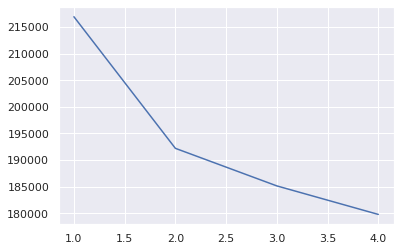

In [69]:
y = np.array([i for i in range(1,5,1)])
plt.plot(y,cost)

In [70]:
## Choosing K=2
km_cao = KModes(n_clusters=2, init = "Cao", n_init = 1, verbose=1)
fitClusters_cao = km_cao.fit_predict(bank_cust)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5322, cost: 192203.0
Run 1, iteration: 2/100, moves: 1160, cost: 192203.0


The result after fit the cluster : 

In [71]:
fitClusters_cao

array([1, 1, 0, ..., 0, 1, 0], dtype=uint16)

Combining the predicted clusters with the original data frame : 

In [72]:
bank_cust = bank_cust_copy.reset_index()

In [73]:
clustersDf = pd.DataFrame(fitClusters_cao)
clustersDf.columns = ['cluster_predicted']
combinedDf = pd.concat([bank_cust, clustersDf], axis = 1).reset_index()
combinedDf = combinedDf.drop(['index', 'level_0'], axis = 1)

Take a look the data after combining : 

In [74]:
combinedDf.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,age_bin,cluster_predicted
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent,50-60,1
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent,50-60,1
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent,30-40,0
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent,30-40,0
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent,50-60,1


 Cluster identification : 

In [75]:
cluster_0 = combinedDf[combinedDf['cluster_predicted'] == 0]
cluster_1 = combinedDf[combinedDf['cluster_predicted'] == 1]

Display cluster info : 

In [76]:
cluster_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28293 entries, 2 to 41187
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   job                28293 non-null  object  
 1   marital            28293 non-null  object  
 2   education          28293 non-null  object  
 3   default            28293 non-null  object  
 4   housing            28293 non-null  object  
 5   loan               28293 non-null  object  
 6   contact            28293 non-null  object  
 7   month              28293 non-null  object  
 8   day_of_week        28293 non-null  object  
 9   poutcome           28293 non-null  object  
 10  age_bin            28293 non-null  category
 11  cluster_predicted  28293 non-null  uint16  
dtypes: category(1), object(10), uint16(1)
memory usage: 2.5+ MB


In [77]:
cluster_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12895 entries, 0 to 41186
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   job                12895 non-null  object  
 1   marital            12895 non-null  object  
 2   education          12895 non-null  object  
 3   default            12895 non-null  object  
 4   housing            12895 non-null  object  
 5   loan               12895 non-null  object  
 6   contact            12895 non-null  object  
 7   month              12895 non-null  object  
 8   day_of_week        12895 non-null  object  
 9   poutcome           12895 non-null  object  
 10  age_bin            12895 non-null  category
 11  cluster_predicted  12895 non-null  uint16  
dtypes: category(1), object(10), uint16(1)
memory usage: 1.1+ MB


Plotting the result based on attributes : 

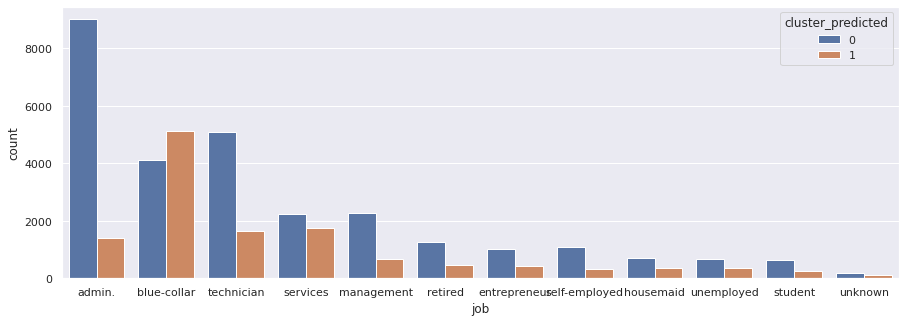

In [78]:
# Job

plt.subplots(figsize = (15,5))
sns.countplot(x=combinedDf['job'],order=combinedDf['job'].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.show()

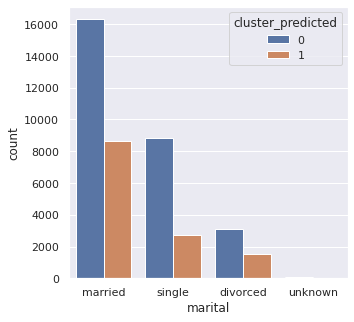

In [79]:
# Marital

plt.subplots(figsize = (5,5))
sns.countplot(x=combinedDf['marital'],order=combinedDf['marital'].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.show()

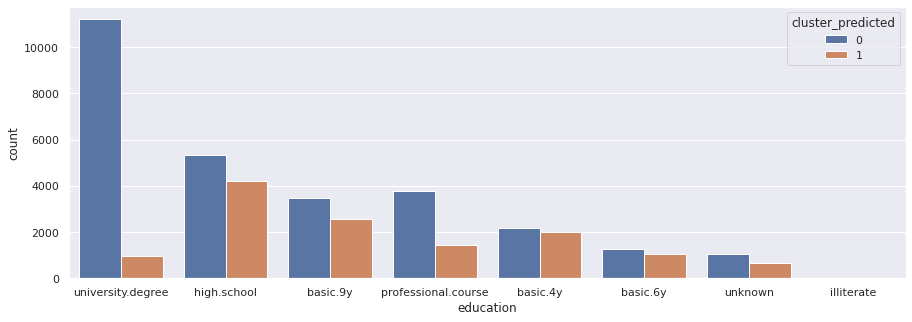

In [80]:
# Education

plt.subplots(figsize = (15,5))
sns.countplot(x=combinedDf['education'],order=combinedDf['education'].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.show()

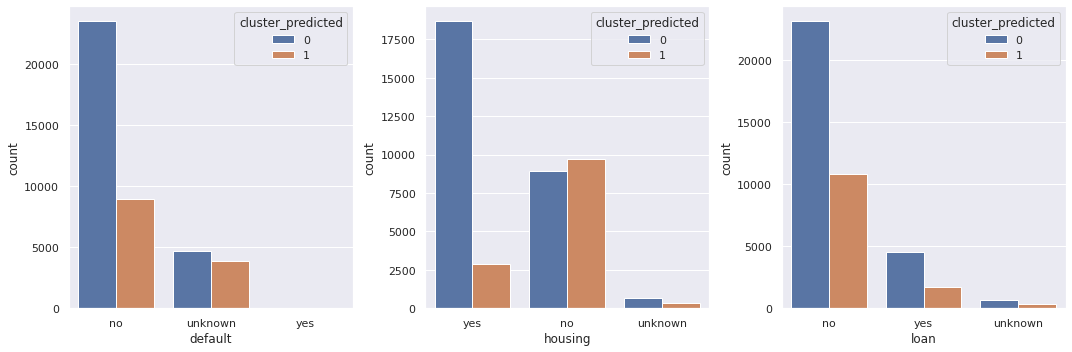

In [81]:
# Default

f, axs = plt.subplots(1,3,figsize = (15,5))
sns.countplot(x=combinedDf['default'],order=combinedDf['default'].value_counts().index,hue=combinedDf['cluster_predicted'],ax=axs[0])
sns.countplot(x=combinedDf['housing'],order=combinedDf['housing'].value_counts().index,hue=combinedDf['cluster_predicted'],ax=axs[1])
sns.countplot(x=combinedDf['loan'],order=combinedDf['loan'].value_counts().index,hue=combinedDf['cluster_predicted'],ax=axs[2])

plt.tight_layout()
plt.show()

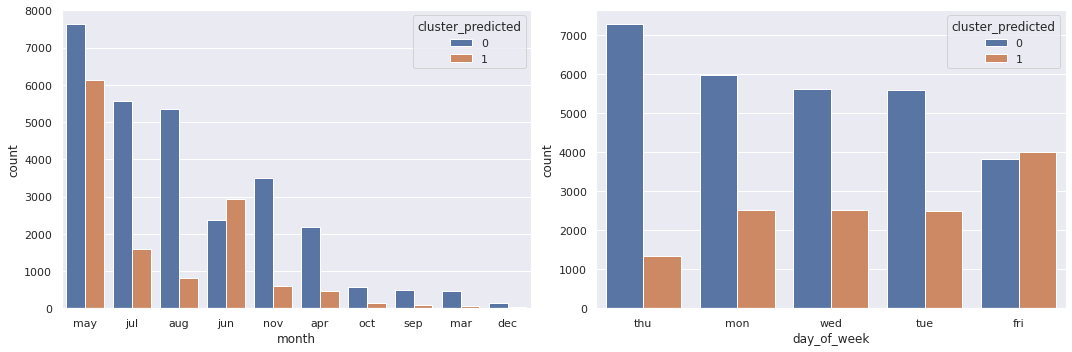

In [82]:
f, axs = plt.subplots(1,2,figsize = (15,5))
sns.countplot(x=combinedDf['month'],order=combinedDf['month'].value_counts().index,hue=combinedDf['cluster_predicted'],ax=axs[0])
sns.countplot(x=combinedDf['day_of_week'],order=combinedDf['day_of_week'].value_counts().index,hue=combinedDf['cluster_predicted'],ax=axs[1])

plt.tight_layout()
plt.show()

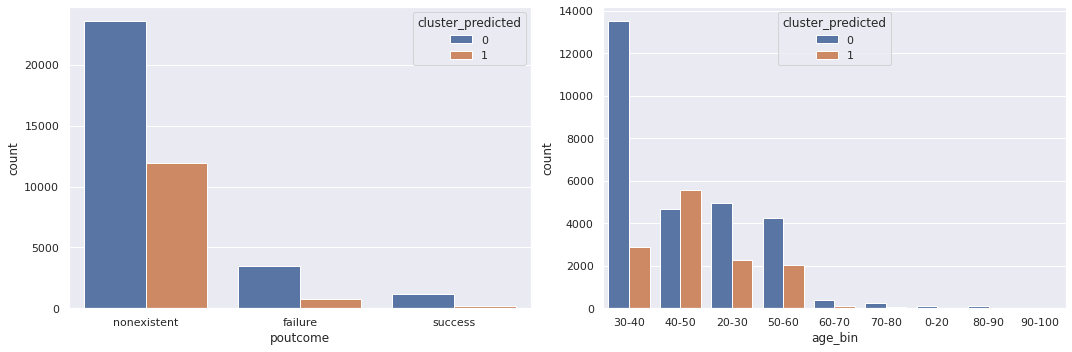

In [83]:
f, axs = plt.subplots(1,2,figsize = (15,5))
sns.countplot(x=combinedDf['poutcome'],order=combinedDf['poutcome'].value_counts().index,hue=combinedDf['cluster_predicted'],ax=axs[0])
sns.countplot(x=combinedDf['age_bin'],order=combinedDf['age_bin'].value_counts().index,hue=combinedDf['cluster_predicted'],ax=axs[1])

plt.tight_layout()
plt.show()

Above visualization can help in identification of clusters.